## Model optimisation - or how to adjust model parameters

***Dependencies***
- numpy
- scipy
- matplotlib
- corner
- emcee

Note: this notebook was originally written in collaboration with Oscar Branson (Cambridge) and Andrew Valentine (ANU-RSES) in the framework of the 'data surgeries' event from the Data Science research theme at RSES.

In [3]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri

import numpy as np
import scipy

# We fix the random seed to always get the same problem

np.random.seed(seed=42)

# Let's continue playing with our simple / fake / known data


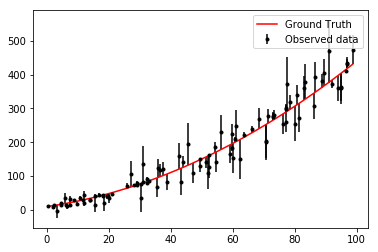

In [4]:
def forward_model(x,a,b,c):
    """return y given x and the a,b,c parameters. This is the direct problem."""
    return a + x*b + c*x*x

# true parameters
a = 10.0
b = 1.321
c = 0.02978

N = 100

x = np.sort(100*np.random.rand(N))
y = forward_model(x,a,b,c)

# Real world observations are noisy...
# but we had a bias in observations and we underestimate the errors
# observed ese are the sum of the two values
f = 0.5 # our systematic bias
ese = f*np.sqrt(y)*5*np.random.randn(N)

y_noisy = y + ese

plt.errorbar(x,y_noisy,yerr=ese,fmt='.',color="k",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.legend()

# Doing better:  more about optimisation and inverse problems

The curve_fit() function is nice, but is only useful for curve fitting. Moreover, error estimations are performed from the parameter covariance matrix pcov, and this may not be always optimal as we saw with CO$_2$. Now, we are going to give a more general definition of the *optimisation* problem, which will allow us to fit complex models.

## The inverse problem

Eq. 1 provides us some observations *d* given a model *m*. This is called the **forward problem**.

Now, it turns out that we have observed *d*, guessed (or constructed from a theory) our model *m*, but have no idea of the parameters.

We can find those with inversion, i.e. solving the [**inverse problem**](https://en.wikipedia.org/wiki/Inverse_problem).

We did that with a common statistical least square approach in the previous cells. Now, we are going to switch from a statistical perspective to a Bayesian perspective. This will improve our vision of modelling, particularly regarding the error determination.

Adopting a Bayesian perspective, there is not a best model, but different models with associated probabilities, a.k.a likelyness. This implies that the most likely model may actually not be the good one, this is just the most likely model...

Another important point of a Bayesian perspective is that we assume some initial knowledge of the model parameters. Contrary to what is done in the curve_fit() function, we can use this knwoledge to improve our ability to determine the parameters of the models, or, more precisely, their probability density function.

In this framework, assuming independent variables, the least square expression (eq. 3) can be generalised as:

$misfit = \sum_{i}{(\frac{d^i_{obs}-g^i(m)}{\sigma^i})^2} + \sum_{\alpha}{(\frac{m^{\alpha}-m^{\alpha}_{prior}}{\sigma_m^{\alpha}})^2}$ , eq. 1

with $\sigma_m$ and $m^{\alpha}_{prior}$ the *à priori* errors and values of our model parameters. We can use this as the misfit function in our optimisation. First, we need to write our [**likelyhood function**](https://en.wikipedia.org/wiki/Likelihood_function), which will allow us to calculate the probability of our model. The commonly used likelyhood function is the gaussian function, with the X axis as the distance of the models to the truth. The formula of a Gaussian is:

$gaussian = exp (-1/2*(\frac{\xi}{\sigma})^2)$ eq. 2

where $\xi$ is an independent variable and $\sigma$ it's standard deviation. Defining $\xi = (d - m)$, we obtain the likelyhood function:

$ likelyhood = exp (-1/2*\frac{(d - m)^2}{\sigma^2})$ eq. 3

We can plot eq. 3 to have a visual insight about it:

Text(0.5,1,'Model likelyhood function')

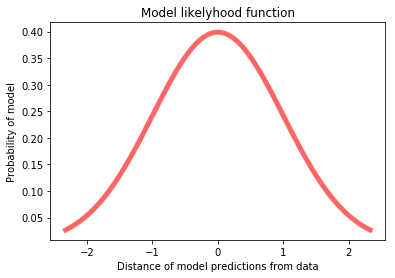

In [5]:
from scipy.stats import norm # this is a normal (gaussian) distribution of mean 0 and sigma 1

dm = np.linspace(norm.ppf(0.01),
                 norm.ppf(0.99), 100)
plt.plot(dm, norm.pdf(dm),
        'r-', lw=5, alpha=0.6, label='norm pdf')

plt.xlabel("Distance of model predictions from data")
plt.ylabel("Probability of model")
plt.title("Model likelyhood function")

It is interesting to see that eq. 3 highlights the origin of the least-square criterion. However, our function is incomplete, because it does not consider the *à prior* information as eq. 4 does. For doing so, we need to defined a [**joint probability distribution**](https://en.wikipedia.org/wiki/Joint_probability_distribution) which will be equal to the sum of the likelyhood probability distribution and the *à prior* model probability distribution:

$JPD = likekyhoodpd + priorpd $, eq. 7

with

$priorpd = exp (-1/2*\frac{(m_{prior} - m)^2}{\sigma_{m}^2})$. eq. 8

In practice, we will see two different forms of the last equation, one for a Gaussian probability and another one for a uniform probability. The graph below summarizes the idea for the *a* parameter:

The *a* parameter has a true value of 10.0. I could make a first-order estimate around 0 from the first figure, so assume 0 ± 20. We also assume a uniform distribution, because it is clear from the first plot that *a* cannot be lower than -20 or higher than 30, so we can say the model should present a uniform probability of 1 between -20 and 30, and a probability of 0 outside this range.

The following code allows generating a figure to compare the two different prior equations.

Text(0,0.5,'Prior probability')

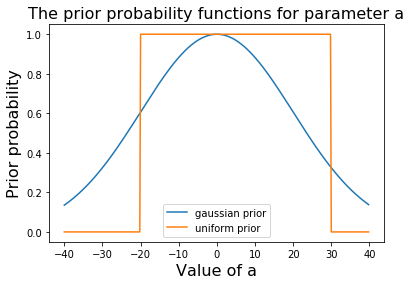

In [6]:
x_a = np.arange(-40,40,0.2)

# a dummy way to do a port function
uni = np.zeros(len(x_a))
uni[(x_a>-20)&(x_a<30)] = 1.0

# plotting things
plt.plot(x_a,np.exp(-1/2*(x_a - 0.0)**2/(20.**2)),label="gaussian prior") 
plt.plot(x_a,uni,label="uniform prior")
plt.legend()
plt.title("The prior probability functions for parameter a",fontsize=16)
plt.xlabel("Value of a",fontsize=16)
plt.ylabel("Prior probability",fontsize=16)

# Putting all those things in usable functions

Usually, the log of the probability distributions are used, as this avoids dealing with 0... We will do that below.

In addition, we are going to add a fudge factor *f* in the likelyhood function to allow us scaling the width of our log likelyhood, which depends on the data errors. This will allow the model to be a bit more independent of the errors we provide, and in fine will allow to take into account any additional error that we were not aware of.

Our formula for the log likelyhood is now:

$ \ln \,p(y\,|\,x,\sigma,m,b,f) =
-\frac{1}{2} \sum_i \left[
  \frac{(d^i-g^{i}(m))^2}{s_i^2}
  + \ln \left ( 2\pi\,s_i^2 \right )
\right]$

with 

$s_i^2 = (f*\sigma_i)^2 $ 

We still find the curvature, but better.

Could we plot the objective function for visualizing it ?

In [7]:
def llf(p,mu,sigma):
    """gaussian distribution (log form)"""
    return -0.5*np.sum((p-mu)**2/sigma**2 + np.log(2*np.pi*sigma**2))

def logprior(theta):
    """log prior probability function for the parameters
    
    This implementation uses a uniform distribution
    
    Parameters
    ==========
    theta : list
        the parameters
        
    Returns
    =======
    logprob_prior : the estimated probability of the prior values
    
    """
    a ,b ,c ,lnf = theta
    
    if -20 < a < 30 \
    and -10 < b < 10 \
    and -10 < c < 10 \
    and -100 < lnf < 1: \
        return 0.0
    else:
        return -np.inf
    
def loglike(theta,x,y,yerr):
    """log likelyhood function
    
    This implementation uses the log of a gaussian distribution
    
    Parameters
    ==========
    theta : list
        the parameters
    x : ndarray
        the X variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
        
    Returns
    =======
    ln_likely : float
        the estimated likelyhood of the a model compared to observations
    
    """
    a ,b ,c ,lnf = theta
    model = forward_model(x,a,b,c)
    ln_likely = llf(model,y,yerr)
    return ln_likely

def logjoint(theta, x,y, yerr):
    """joint probability function
    
    This implementation uses the log of a gaussian distribution
    
    Parameters
    ==========
    theta : list
        the parameters
    x : ndarray
        the X variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
        
    Returns
    =======
    ln_prob : float
        the total likelyhood of a model compared to observations
    
    """
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(theta,x,y,yerr)

# First step: estimate the maximum of the distribution

Now we can find the maximum likelyhood of this distribution using the minimize() function from scipy.optimize

We first define our prior model as list containing our estimates of initial *a*, *b*, *c* values plus an estimate of the scaling of the likelyhood distribution.

In [8]:
theta_prior = [0.,1.,0.01,-2]

Let's check if this model is probable with the logprior function

In [9]:
if logprior(theta_prior) == 0:
    print("Model viable")

Model viable


# Second step

OK, seems we can go. Now, we estimate the maximum likelyhood valeu with scipy.optimize.minimize

In [10]:
# Find the maximum likelihood value.
import scipy.optimize as op

chi2 = lambda *args: -2 * logjoint(*args)
result = op.minimize(chi2, theta_prior, args=(x, y_noisy,ese))
print(result)

      fun: 787.5424645952526
 hess_inv: array([[ 1.22186121e-01, -8.38049799e-03,  9.72383098e-05,
         0.00000000e+00],
       [-8.38049799e-03,  6.15041718e-04, -8.10821104e-06,
         0.00000000e+00],
       [ 9.72383098e-05, -8.10821104e-06,  1.43911747e-07,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
      jac: array([-0.00092316, -0.02092743, -0.38674164,  0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 272
      nit: 5
     njev: 43
   status: 2
  success: False
        x: array([10.61756036,  1.27972395,  0.03040392, -2.        ])


Obtained parameters with curve_fit:
[10.61757619  1.27972248  0.03040396]
Obtained parameters with Log Likelyhood:
[10.61756036  1.27972395  0.03040392 -2.        ]
Estimated bias
0.1353352832366127
Fit RMSE is: 83603.85588736726


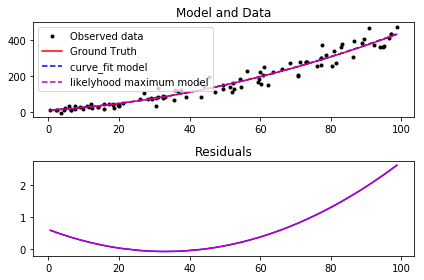

In [11]:
# getting old results with curve_fit for comparison
popt, pcov = op.curve_fit(forward_model,x,y_noisy,sigma=ese)
y_pred_curvefit = forward_model(x,*popt)

# Result is a dictionary, the best parameters are the x values.
popt_2 = result['x'][:-1]

print("Obtained parameters with curve_fit:")
print(popt)

print("Obtained parameters with Log Likelyhood:")
print(result['x'])

print("Estimated bias")
print(np.exp(result['x'][-1]))

# we calculate the best estimate
y_pred_minimize = forward_model(x,*popt_2) # parameter unwrapping (*popt) works only in Python 3

print("Fit RMSE is: "+str(np.sum((y_pred_minimize-y_noisy)**2)))

plt.figure()

plt.subplot(2,1,1)
plt.plot(x,y_noisy,"k.",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x,y_pred_curvefit,"b--",label="curve_fit model")
plt.plot(x,y_pred_minimize,"m--",label="likelyhood maximum model")
plt.title("Model and Data")
plt.legend()

plt.subplot(2,1,2)
plt.plot(x,(y_pred_curvefit - y),"b-")
plt.plot(x,(y_pred_minimize - y),"m-")
plt.title("Residuals")

plt.tight_layout()

OK, we get a similar result, which makes sense as we are virtually performing the same thing: least square on a simple problem. However, we did not sample our probability distribution. To do that, we have two ways: using an existing Python library, or building our own function.

We will do both, as the later will allow understanding the concept, and using an existing library will allow more flexibility and robustness.

We are going to do implement first a very simple [*markov-chain monte carlo*](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) algorithm, called the [Metropolis Hasting](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm. The concept of this algorithm is simple: 

- generate a new model from a perturbation of the old one
- look at its probability
- accept the new model if its probability is higher than that of the old
- if lower, still leave a chance to accept it with a probability of X %


In [12]:
def mcmc(x,y,yerr,theta_prior,scales,nb_iter):
    """MCMC Metropolis Hasting function to fit simple data
    
    Parameters
    ==========
    x : ndarray
        the X variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
    theta_prior : list
        the estimates of model parameters
    scales : list
        scaling factor for perturbating the parameters
    nb_iter : int
        number of iterations to perform = number of sampled models
        
    Returns
    =======
    theta_record : ndarray, shape = (nb_iter,size(theta_prior))
        the estimates of model parameters
    logrecord : 1D array
        the log probabilities of the nb_iter models
    acceptance_rate : 1D array
        the acceptance rate for each parameter
        
    """
    logrecord = np.zeros(nb_iter)
    theta_record = np.zeros((nb_iter,len(theta_prior)))
    
    # to calculated acceptance rate
    accepted = np.array([0, 0, 0, 0])
    
    logrecord[0] = logjoint(theta_prior,x,y,yerr)
    theta_record[0,:] = theta_prior
    
    i = 1
    ip = 0 # for selecting the parameter to perturbate
    while i < nb_iter:
        
        # we perturbate our parameter, index ip
        theta_0 = theta_record[i-1,:]
        theta_0[ip] += scales[ip]*np.random.randn()
        
        logprob_theta0 = logjoint(theta_0,x,y,yerr)
        
        alpha = logprob_theta0 - logrecord[i-1]
        
        if alpha > np.log(np.random.rand()): # if our probability is actually higher than the previous
            logrecord[i] = logprob_theta0
            theta_record[i,:] = theta_0
            accepted[ip] = accepted[ip] + 1
        else: # if it is not, we still leave a chance to accept the model
            logrecord[i] = logrecord[i-1]
            theta_record[i,:] = theta_record[i-1,:]
        
        i += 1 # incrementing i as well as the number of tested models
        
        # we increment pi up to 3 and if it was 3, we go back to 0
        if ip == 3:
            ip = 0
        else:
            ip += 1
            
    # calculation of acceptance rates
    acceptance_rate = accepted/(nb_iter-1)
    
    return theta_record, logrecord, acceptance_rate  

Now the tricky part in this type of algorithm is to adjust the scaling parameters, which defines the size of the jumps your random walk is doing.

To adjust that, we can have a first look at how much we affect the parameters. It should be of a small fraction only, but not too small also...

Another thing: as mcmc calculations can be expensive, a good practice can be to start from the maximum of the log likelyhood determined through gradient descent...

In [13]:
theta_prior = result['x'] 

scales = np.array([1e-3,1e-3,1e-6,1e-6])
scales_test = scales[:]*np.random.randn(4)
print("Parameters prior: "+str(theta_prior)) 
print("Perturbations: "+str(scales_test))


Parameters prior: [10.61756036  1.27972395  0.03040392 -2.        ]
Perturbations: [ 1.30018919e-05  1.45353408e-03 -2.64656833e-07  2.72016917e-06]


Seems not too bad, let's give it a go.

In [14]:
nb_iter=10000
theta_mcmc_chain1, logrecord_mcmc_chain1, acceptance_rate_chain1 = mcmc(x,y_noisy,ese,theta_prior,scales,nb_iter)
theta_mcmc_chain2, logrecord_mcmc_chain2, acceptance_rate_chain2 = mcmc(x,y_noisy,ese,theta_prior,scales,nb_iter)
theta_mcmc_chain3, logrecord_mcmc_chain3, acceptance_rate_chain3 = mcmc(x,y_noisy,ese,theta_prior,scales,nb_iter)

# Result analysis

The first thing to do with MCMC will be to check if we reach some sort of stability.

We do that by plotting the parameters as a function of the number of iterations.

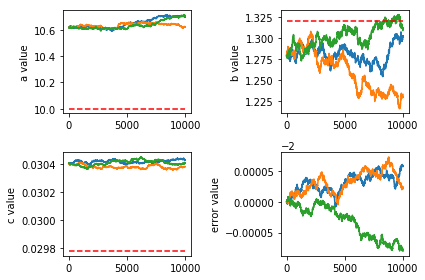

In [15]:
plt.figure()

plt.subplot(2,2,1)
plt.plot(theta_mcmc_chain1[:,0],label="chain 1")
plt.plot(theta_mcmc_chain2[:,0],label="chain 2")
plt.plot(theta_mcmc_chain3[:,0],label="chain 3")
plt.plot([0,nb_iter],[a,a],"r--")
plt.ylabel("a value")

plt.subplot(2,2,2)
plt.plot(theta_mcmc_chain1[:,1],label="chain 1")
plt.plot(theta_mcmc_chain2[:,1],label="chain 2")
plt.plot(theta_mcmc_chain3[:,1],label="chain 3")
plt.plot([0,nb_iter],[b,b],"r--")
plt.ylabel("b value")

plt.subplot(2,2,3)
plt.plot(theta_mcmc_chain1[:,2],label="chain 1")
plt.plot(theta_mcmc_chain2[:,2],label="chain 2")
plt.plot(theta_mcmc_chain3[:,2],label="chain 3")
plt.plot([0,nb_iter],[c,c],"r--")
plt.ylabel("c value")

plt.subplot(2,2,4)
plt.plot(theta_mcmc_chain1[:,3],label="chain 1")
plt.plot(theta_mcmc_chain2[:,3],label="chain 2")
plt.plot(theta_mcmc_chain3[:,3],label="chain 3")
plt.ylabel("error value")

plt.tight_layout()

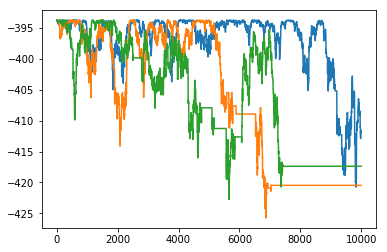

In [16]:
plt.plot(logrecord_mcmc_chain1)
plt.plot(logrecord_mcmc_chain2)
plt.plot(logrecord_mcmc_chain3)

# Looking at the acceptance rates. They should be around 0.2 to 0.5, optimally at 0.3.

In [17]:
print(acceptance_rate_chain1)
print(acceptance_rate_chain2)
print(acceptance_rate_chain3)

[0.23932393 0.21312131 0.22952295 0.2380238 ]
[0.14211421 0.12391239 0.13471347 0.14091409]
[0.14231423 0.11821182 0.13051305 0.13871387]


# How errors compare with pcov ?

In [18]:
a_mcmc = np.mean((theta_mcmc_chain1[:,0],theta_mcmc_chain2[:,0],theta_mcmc_chain3[:,0]))
b_mcmc = np.mean((theta_mcmc_chain1[:,1],theta_mcmc_chain2[:,1],theta_mcmc_chain3[:,1]))
c_mcmc = np.mean((theta_mcmc_chain1[:,2],theta_mcmc_chain2[:,2],theta_mcmc_chain3[:,2]))
lnf_mcmc = np.mean((theta_mcmc_chain1[:,3],theta_mcmc_chain2[:,3],theta_mcmc_chain3[:,3]))

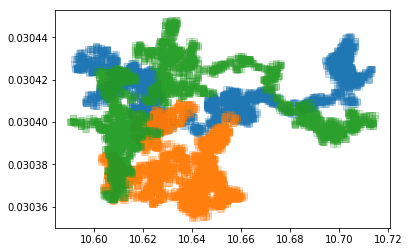

In [19]:
plt.plot(theta_mcmc_chain1[:,0],theta_mcmc_chain1[:,2],"s",alpha=0.1)
plt.plot(theta_mcmc_chain2[:,0],theta_mcmc_chain2[:,2],"s",alpha=0.1)
plt.plot(theta_mcmc_chain3[:,0],theta_mcmc_chain3[:,2],"s",alpha=0.1)

(array([ 204., 4256., 1188., 1624.,  344.,  212.,  380.,  544.,  824.,
         424.]),
 array([10.59047335, 10.60288413, 10.61529492, 10.6277057 , 10.64011648,
        10.65252726, 10.66493804, 10.67734883, 10.68975961, 10.70217039,
        10.71458117]),
 <a list of 10 Patch objects>)

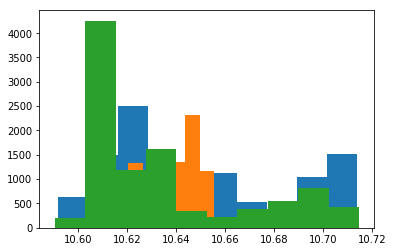

In [20]:
plt.hist(theta_mcmc_chain1[:,0])
plt.hist(theta_mcmc_chain2[:,0])
plt.hist(theta_mcmc_chain3[:,0])

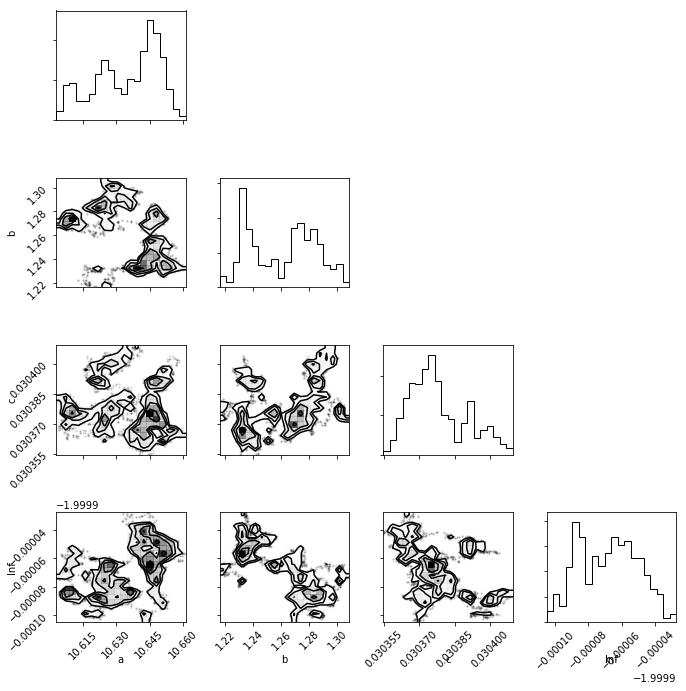

In [21]:
import corner
labels = ['a','b','c','lnf']
fig_mh = corner.corner(theta_mcmc_chain2,labels=labels,truths=[a, b, c, np.log(f)])
plt.tight_layout()

We see the random walk there, but our simple algorithm did not sample all the possible space in term of a, b and c parameters

Using a real library (or better code but optimised and probably running in a fast language as C or C++ or Julia) can do a better job.

We will show that with the EMCEE library below.

# EMCEE

In [22]:
import emcee

# Set up the sampler.
ndim, nwalkers = len(theta_prior), 100
pos = [result["x"] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, logjoint, args=(x, y,ese))

# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, 500, rstate0=np.random.get_state())
print("Done.")

Running MCMC...
Done.


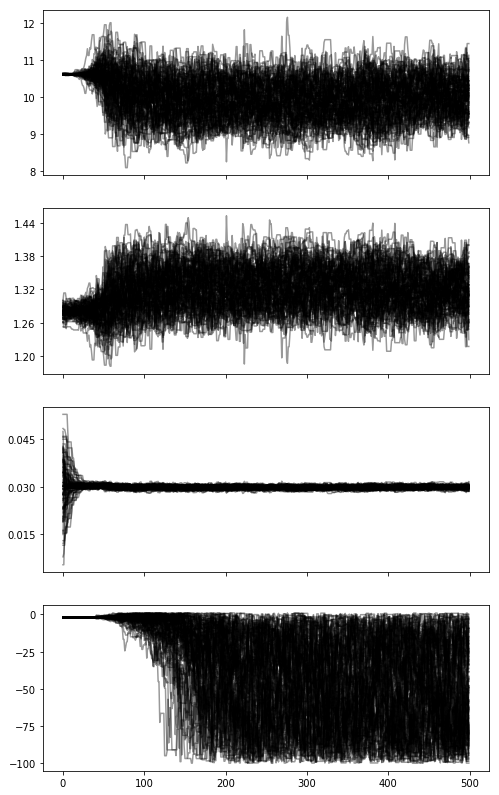

In [26]:
fig, axes = plt.subplots(len(theta_prior), 1, sharex=True,figsize=(8,14))

for i in range(len(theta_prior)):
    axes[i].plot(sampler.chain[:, :, i].T, color="k", alpha=0.4)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    #axes[i].axhline(m_true, color="#888888", lw=2)
    #axes[i].set_ylabel("$m$")

# Burnin

From the above plot, we see that convergence was reached after 200 iterations. We thus will trash the first 200 iterations in our posterior analysis

In [27]:
# Make the triangle plot.
burnin = 200
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

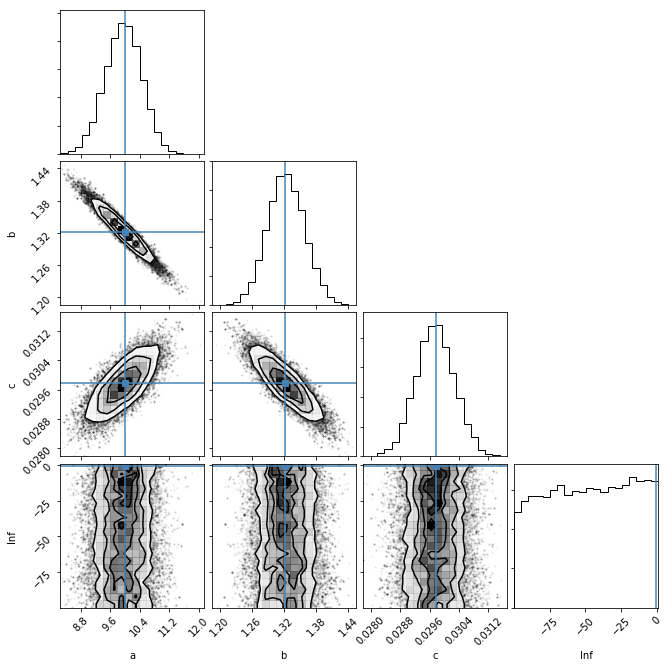

In [28]:
labels = ['a','b','c','lnf']
fig_emcee = corner.corner(samples,labels=labels,truths=[a, b, c, np.log(f)])

EMCEE does a much better job than our previous simple metropolis hasting algorithm.

And is much faster.


# Plotting 500 models

In [29]:
nb_samples = 500
rand_sel = np.random.randint(0,samples.shape[0],nb_samples)

models_emcee_sampled = [forward_model(x,*samples[rand_sel[i]][:-1]) for i in range(nb_samples)]

y_pred_emcee = forward_model(x,*np.median(samples,axis=0)[:-1])

models_emcee_median = np.median(models_emcee_sampled,axis=0)

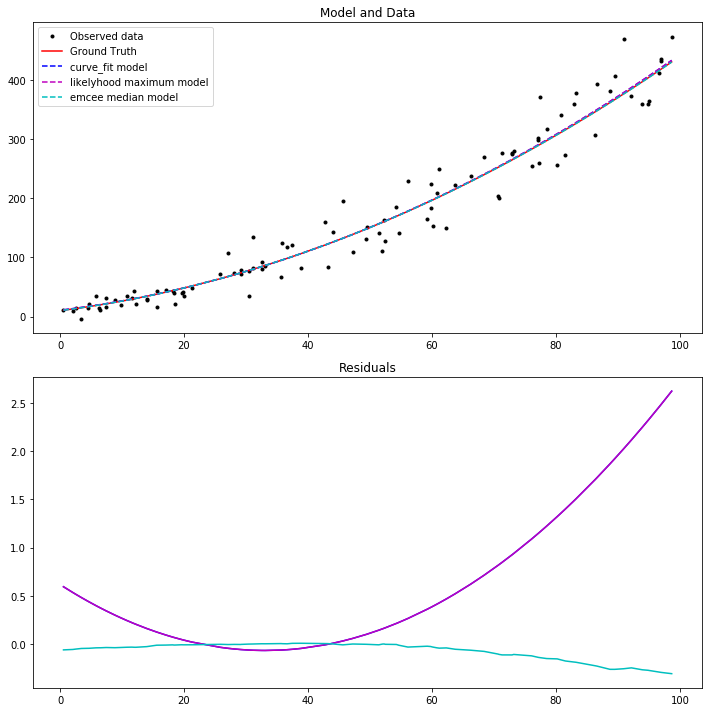

In [30]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(x,y_noisy,"k.",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x,y_pred_curvefit,"b--",label="curve_fit model")
plt.plot(x,y_pred_minimize,"m--",label="likelyhood maximum model")
plt.plot(x,models_emcee_median,"c--",label="emcee median model")
    
plt.title("Model and Data")
plt.legend()

plt.subplot(2,1,2)
plt.plot(x,(y_pred_curvefit - y),"b-")
plt.plot(x,(y_pred_minimize - y),"m-")
plt.plot(x,(models_emcee_median- y),"c-")
plt.title("Residuals")

plt.tight_layout()